# Copy to thesis figures

In [143]:
import os
import shutil

sourceDir = './visualizations'
destDir = '/home/slarty/Documents/master-thesis/src/thesis/figures/visualizations'

for filename in os.listdir(sourceDir):
    if filename.endswith('.pdf'):
        shutil.copy(os.path.join(sourceDir, filename), destDir)

# Utils

## Data models

In [132]:
from typing import List
from typing import Callable
from typing import Tuple

class Rectangle:
    
    def __init__(self, width=0, height=0, x=0, y=0, ident=1):
        self.width = width
        self.height = height
        self.x = x
        self.y = y
        self.ident = ident
        self.centerX = x+width/2
        self.centerY = y+height/2
    
    def __str__(self):
        return f'{self.ident}: ({self.width},{self.height},{self.x},{self.y}) whxy'
    
    def checkOverlap(self, other):
        """
        Check if two Rectangle objects overlap.
        Return True if they overlap, False otherwise.
        """
        x_overlap = max(0, min(self.x + self.width, other.x + other.width) - max(self.x, other.x))
        y_overlap = max(0, min(self.y + self.height, other.y + other.height) - max(self.y, other.y))
        overlap_area = x_overlap * y_overlap
        return overlap_area > 0
    
def decodeIntList(lst: List[str]) -> List[int]:
    return list(map(int, lst))

def decodeFloatList(lst: List[str]) -> List[float]:
    return list(map(float, lst))

def decodeRectangles(lst: List[str], idents: List[str]) -> List[Rectangle]:
    return list(map(decodeRectangle, *(lst,idents)))

def decodeRectangle(rec: str, ident: str) -> Rectangle:
    x,y,w,h = rec.split(',')
    return Rectangle(x=int(x), y=int(y), width=int(w), height=int(h), ident=ident)


class Individual:
    def __init__(self, iteration: int, objectiveValue: int, paintingSeq: List[int], paintingSeqDecoded: List[int], paintingSeqRandomKey: List[float], slicingOrderDecoded: List[int], slicingOrderRandomKey: List[float], orientations: List[str], orientationsCapped: List[str], orientationsResolved: List[str], paintingAllocatedSpace: List[Rectangle], paintingPlacement: List[Rectangle]):
        self.iteration = iteration
        self.objectiveValue = objectiveValue
        self.paintingSeq = paintingSeq
        self.paintingSeqDecoded = paintingSeqDecoded
        self.paintingSeqRandomKey = paintingSeqRandomKey
        self.slicingOrderDecoded = slicingOrderDecoded
        self.slicingOrderRandomKey = slicingOrderRandomKey
        self.orientations = orientations
        self.orientationsCapped = orientationsCapped
        self.orientationsResolved = orientationsResolved
        self.paintingAllocatedSpace = paintingAllocatedSpace
        self.paintingPlacement = paintingPlacement
        
    @staticmethod
    def create(json: dict) -> 'Individual':
        return Individual(
            iteration=int(json['iteration']),
            objectiveValue=float(json['objectiveValue']),
            paintingSeq=json['paintingSeq'],
            paintingSeqDecoded=json['paintingSeqDecoded'],
            paintingSeqRandomKey=decodeFloatList(json['paintingSeqRandomKey']),
            slicingOrderDecoded=decodeIntList(json['slicingOrderDecoded']),
            slicingOrderRandomKey=decodeFloatList(json['slicingOrderRandomKey']),
            orientations=json['orientations'],
            orientationsCapped=json['orientationsCapped'],
            orientationsResolved=json['orientations'], # TODO provide resolved orientations
            paintingAllocatedSpace=decodeRectangles(json['paintingAllocatedSpace_XYWH'], json['paintingSeqDecoded']),
            paintingPlacement=decodeRectangles(json['paintingPlacement_XYWH'], json['paintingSeqDecoded']))
    
class Painting:
    def __init__(self, ident: str, width: int, height: int):
        self.ident = ident
        self.width = width
        self.height = height
        
    @staticmethod
    def create(json: dict) -> 'Painting':
        return Painting(
            ident=json['ident'],
            width=int(json['width']),
            height=int(json['height']))
    
class HallOfFameRecord:
    def __init__(self, iteration: int, objectiveMin: float, objectiveMax: float, objectiveAvg: float, standardDeviation: float, bestIndividual: Individual):
        self.iteration = iteration
        self.objectiveMin = objectiveMin
        self.objectiveMax = objectiveMax
        self.objectiveAvg = objectiveAvg
        self.standardDeviation = standardDeviation
        self.bestIndividual = bestIndividual
    
    @staticmethod
    def create(json: dict) -> 'HallOfFameRecord':
        return HallOfFameRecord(
            iteration=int(json['iteration']),
            objectiveMin=float(json['objectiveMin']),
            objectiveMax=float(json['objectiveMax']),
            objectiveAvg=float(json['objectiveAvg']),
            standardDeviation=float(json['standardDeviation']),
            bestIndividual=Individual.create(json['bestIndividual']))
            
class GaResult:
    def __init__(self, bestIndividual: Individual, hallOfFame: List[HallOfFameRecord]):
        self.bestIndividual = bestIndividual
        self.hallOfFame = hallOfFame
        
    @staticmethod
    def create(json: dict) -> 'GaResult':
        return GaResult(
            bestIndividual=Individual.create(json['bestIndividual']),
            hallOfFame=list(map(HallOfFameRecord.create, json['hallOfFame']['records'])))

class GaParameters:
    def __init__(self, maxNumberOfIter: int, populationSize: int, maximumWildCardCount: int, geneticAlgorithm: str, orientationWeights: List, populationDivisionCounts: dict, initialPopulationDivisionCounts: dict, mate: str, mutate: str, select: str):
        self.maxNumberOfIter = maxNumberOfIter
        self.populationSize = populationSize
        self.maximumWildCardCount = maximumWildCardCount
        self.geneticAlgorithm = geneticAlgorithm
        self.orientationWeights = orientationWeights
        self.populationDivisionCounts = populationDivisionCounts
        self.initialPopulationDivisionCounts = initialPopulationDivisionCounts
        self.mate = mate
        self.mutate = mutate
        self.select = select
        
    @staticmethod
    def create(json: dict) -> 'GaParameters':
        return GaParameters(
            maxNumberOfIter=int(json['maxNumberOfIter']),
            populationSize=int(json['populationSize']),
            maximumWildCardCount=int(json['maximumWildCardCount']),
            geneticAlgorithm=json['geneticAlgorithm'],
            orientationWeights=json['orientationWeights'],
            populationDivisionCounts=json['populationDivisionCounts'],
            initialPopulationDivisionCounts=json['initialPopulationDivisionCounts'],
            mate=json['mate'],
            mutate=json['mutate'],
            select=json['select'])

class Layout:
    def __init__(self, width: int, height: int, evalFunc: str):
        self.width = width
        self.height = height
        self.evalFunc = evalFunc
        self.boundingRectangle = Rectangle(width=width, height=height, x=0, y=0, ident="")
        
    @staticmethod
    def create(json: dict) -> 'Layout':
        return Layout(width=json['width'], height=json['height'], evalFunc=json['evalFunc'])
    
class Flow:
    def __init__(self, src: int, dst: int, flow: float):
        self.src = src
        self.dst = dst
        self.flow = flow
        
    @staticmethod
    def create(json: dict) -> 'Flow':
        return Flow(
            src=json['from'],
            dst=json['to'],
            flow=float(json['flow']))
    
class InstanceParameters:
    def __init__(self, layout: Layout, paintings: List[Painting], paintingsFlow: List[Flow]):
        self.layout = layout
        self.paintings = paintings
        self.paintingsFlow = paintingsFlow
        
    @staticmethod
    def create(json: dict) -> 'InstanceParameters':
        return InstanceParameters(
            layout=Layout.create(json['layout']),
            paintings=list(map(Painting.create, json['paintings'])),
            paintingsFlow=list(map(Flow.create, json['paintingsFlow'])))
    
class ObjectiveParameters:
    def __init__(self, name: str, params: dict):
        self.name = name
        self.params = params
        self.overlappingPenalizationConstant = params['overlappingPenalizationConstant'] # hotfix
    
    def __getattr__(self, name):
        if name in self.params:
            return self.params[name]
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'")

        
    @staticmethod
    def create(json: dict) -> 'ObjectiveParameters':
        return ObjectiveParameters(
            name=json['name'],
            params=json['params'])
        

class ComputationResult:
    def __init__(self, applicationVersion: str, createdAt: str, durationMillis: int, gaResult: GaResult, gaParameters: GaParameters, instanceParameters: InstanceParameters, objectiveParameters: ObjectiveParameters, name: str = None):
        self.applicationVersion = applicationVersion
        self.createdAt = createdAt
        self.durationMillis = durationMillis
        self.gaResult = gaResult
        self.gaParameters = gaParameters
        self.instanceParameters = instanceParameters
        self.objectiveParameters = objectiveParameters
        self.name = name
        
    @staticmethod
    def createWithName(name: str, json: dict):
        compRes = ComputationResult.create(json)
        compRes.name = name
        return compRes
    
    @staticmethod
    def create(json: dict) -> 'ComputationResult':
        return ComputationResult(
            applicationVersion=json['applicationVersion'],
            createdAt=json['createdAt'],
            durationMillis=int(json['durationMillis']),
            gaResult=GaResult.create(json['gaResult']),
            gaParameters=GaParameters.create(json['gaParameters']),
            instanceParameters=InstanceParameters.create(json['instanceParameters']),
            objectiveParameters=ObjectiveParameters.create(json['objectiveParameters']))
    
class Dataset:
    def __init__(self, name: str, instanceParameters: InstanceParameters):
        self.name = name
        self.instanceParameters = instanceParameters
        self.data = instanceParameters
        
    @staticmethod
    def create(json: dict) -> 'Dataset':
        return Dataset(
            name=json['name'],
            instanceParameters=InstanceParameters.create(json['data']))

## Helpers

In [8]:
import os
import json

def flatten(lst):
    flattened = []
    for sublist in lst:
        for item in sublist:
            flattened.append(item)
    return flattened

def findComputationResultFiles(directory):
    """Recursively searches a directory for files named 'computation_result.json'
    and returns a list of their paths using camel case."""

    resultFiles = []
    
    for item in os.listdir(directory):
        path = os.path.join(directory, item)
        
        if os.path.isdir(path):
            resultFiles += findComputationResultFiles(path)
        
        elif os.path.isfile(path) and item.lower() == 'computation_result.json':
            resultFiles.append(path)
    
    return resultFiles

def extractDatasetName(path):
    return path.split('/')[-2].rsplit('_',1)[0].split('_', 1)[1] # magic

def loadComputationResult(path, log=False) -> ComputationResult:
    if log:
        print(f'loading: {path}')
    with open(path, 'r') as f:
        data = json.load(f)
    
    return ComputationResult.createWithName(extractDatasetName(path), data)

def loadOneComputationResultsFromDirectoryRec(directory):
    r = list(map(loadComputationResult, findComputationResultFiles(directory)))
    if len(r) != 1:
        raise ValueError(f'There are {len(r)} results for [{directory}]. One expected')
    return r[0]

## Drawing

In [140]:
import matplotlib
import matplotlib.pyplot as plt

def hideSpinesAndTicks(ax):
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.axis('off')
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.spines.top.set_visible(False)    

def toMatplotlibRec(rec, fill=False, **kwargs):
    r = matplotlib.patches.Rectangle(
        (rec.x, rec.y),
        width=rec.width,
        height=rec.height,
        fill=fill,
        **kwargs)
    r.set_clip_on(False) # magic from https://stackoverflow.com/a/6700352/6784881
    return r

def drawRectangle(
    rec: Rectangle,
    ax,
    fill=False,
    show_center=False, show_ident=False,
    **kwargs):
    ax.add_patch(toMatplotlibRec(rec=rec, fill=fill, **kwargs))
    cx, cy = rec.x+rec.width/2, rec.y+(rec.height/2)
    
    if show_center:
        ax.scatter(rec.centerX, rec.centerY, color='black', s=1, alpha=1)
    if show_ident:
        k = 1.13 if show_center else 1
        rotation = 90 if rec.ident.startswith('bottom') else 0
        ax.text(rec.centerX*k*0.95, rec.centerY*k*0.95, rec.ident, fontsize=8, rotation=rotation)
        
def generateClusterColors(cluster):
    colors = ['red', 'yellow', 'blue', 'green']
    cnt, size = cluster
    return flatten([[colors[i]]*size for i in range(cnt)])

def drawRectangles(
    ax,
    recs: List[Rectangle],
    grid: Rectangle,
    dim=None,
    cluster=None,
    show_ident=True, title=None, show_center=False):
    
    xmax, ymax = max(grid.width, max([r.x+r.width for r in recs])), max([r.y+r.height for r in recs])
    xmin, ymin = min(0, min([r.x+r.width for r in recs])), min(0, min([r.y+r.height for r in recs]))
    print(f'xmin={xmin}, xmax={xmax}, ymin={ymin}, ymax={ymax}')
    print(f'grid width={grid.width}, grid height={grid.height}')
    ax.axis(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    
    
    drawRectangle(grid, ax, edgecolor='black', linewidth=1.4, alpha=0.5)
    if cluster is None:
        for rec in recs :
            drawRectangle(rec, ax, show_center=show_center, linewidth=1.1, edgecolor='black',
                      show_ident=show_ident)
    else:
        for rec,color in zip(sorted(recs, key=lambda x: int(x.ident)), generateClusterColors(cluster)):
            drawRectangle(rec, ax, show_center=False, linewidth=1.1, edgecolor='black',
                      show_ident=False)
            drawRectangle(rec, ax, fill=True, show_center=show_center, linewidth=1.1,
                          show_ident=show_ident, color=color, alpha=0.5)

    if title:
        ax.set_title(f'{title}', fontsize=8)
    hideSpinesAndTicks(ax)
    
def getLastIteration(compRes, lastIterNum):
    last = compRes.gaResult.hallOfFame[-1]
    if last.iteration != lastIterNum:
        raise ValueError(f'Last iteration must be {lastIterNum}. It is {last.iteration}.')
    return last

def getOverlapCount(recLst: List[Rectangle]) -> int:
    cnt = 0
    for i in range(len(recLst)):
        for j in range(i+1, len(recLst)):
            if recLst[i].checkOverlap(recLst[j]):
                cnt += 1
    return cnt

def drawComputationResult(res, lastIterNum, dim=None, cluster=None, show_ident=True):
    last = getLastIteration(res,lastIterNum)
    print(f'objectiveMin={last.objectiveMin}, objectiveMax={last.objectiveMax}, objectiveAvg={last.objectiveAvg}, std={last.standardDeviation}, overlappings={getOverlapCount(last.bestIndividual.paintingPlacement)}')
    fig, ax = plt.subplots(dpi=150)
    drawRectangles(
            ax=ax,
            recs=last.bestIndividual.paintingPlacement,
            show_center=False,
            show_ident=show_ident,
            grid=res.instanceParameters.layout.boundingRectangle,
            title=None,
            dim=dim,
            cluster=cluster)
    plt.title(f'{res.name} instance')
    plt.savefig(f'visualizations/visualization_{res.name}.pdf', transparent=True, bbox_inches='tight')
    plt.show()

# Visualizations

In [117]:
from pathlib import Path
RESULT_DIR = Path('/home/slarty/Documents/master-thesis/src/notebooks/out_results/results_2023_04_29_01:27:36')
RESULT_DIR = Path('/home/slarty/Documents/master-thesis/src/notebooks/out_results/results_2023_04_29_14:09:51')

## Batch

===random_10===
objectiveMin=1106.33, objectiveMax=2932.9, objectiveAvg=1475.31, std=319.91, overlappings=1
xmin=0, xmax=24, ymin=0, ymax=20
grid width=24, grid height=19


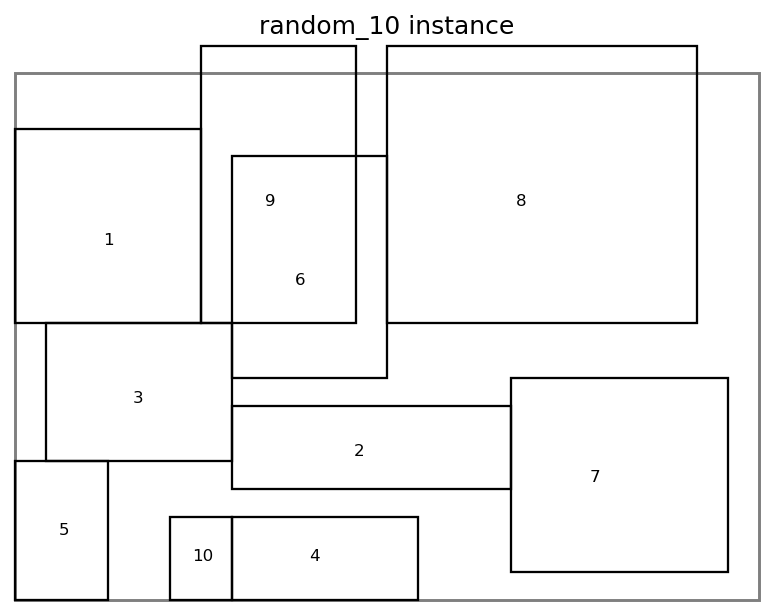


===random_20===
objectiveMin=5106.49, objectiveMax=8617.66, objectiveAvg=5521.33, std=647.47, overlappings=2
xmin=0, xmax=37, ymin=0, ymax=27
grid width=31, grid height=25


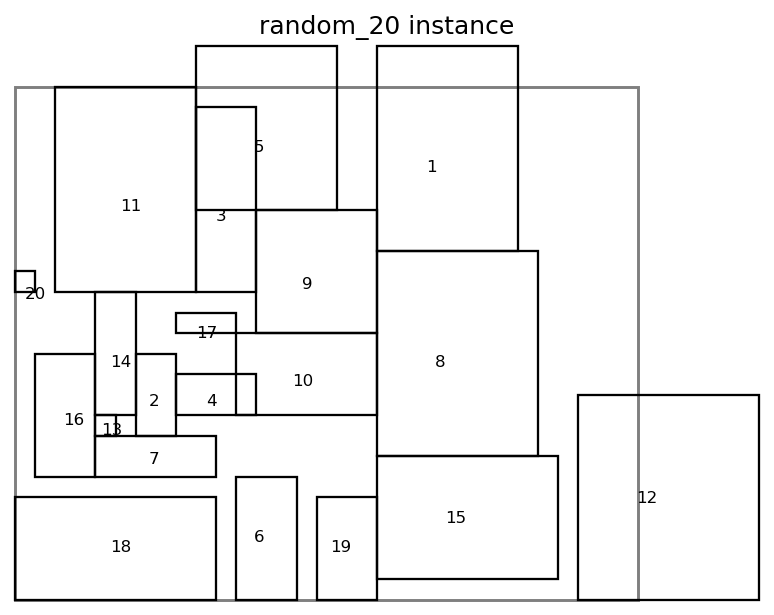


===packing_10===
objectiveMin=716.55, objectiveMax=1482.71, objectiveAvg=748.28, std=126.11, overlappings=0
xmin=0, xmax=21, ymin=0, ymax=16
grid width=19, grid height=15


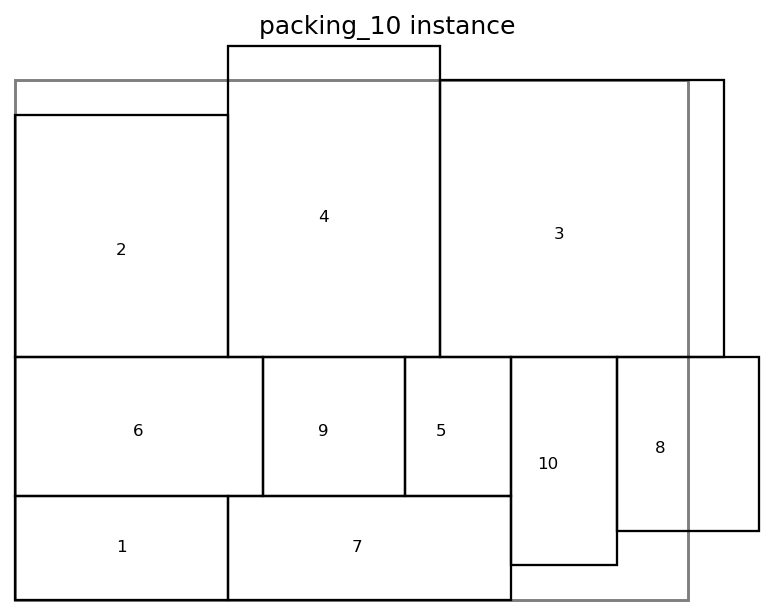


===packing_20===
objectiveMin=6607.76, objectiveMax=10881.3, objectiveAvg=6996.43, std=792.16, overlappings=8
xmin=0, xmax=39, ymin=0, ymax=29
grid width=33, grid height=26


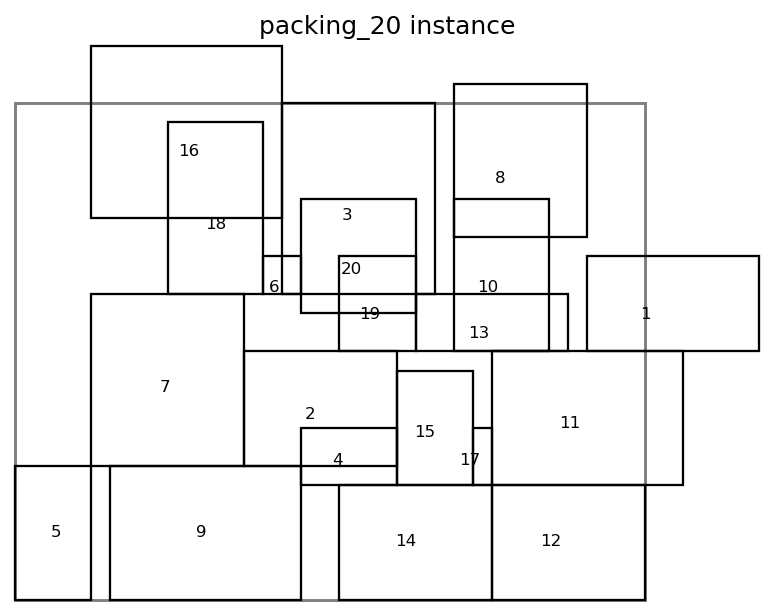


===cluster_3_6===
objectiveMin=4940.93, objectiveMax=8924.68, objectiveAvg=5258.09, std=517.73, overlappings=4
xmin=0, xmax=36, ymin=0, ymax=30
grid width=30, grid height=25


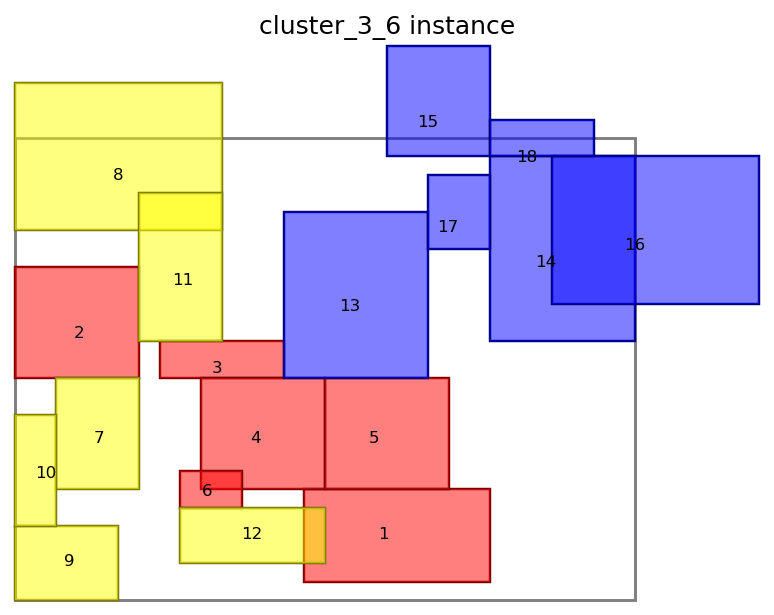


===cluster_4_5===
objectiveMin=5080.58, objectiveMax=9664.94, objectiveAvg=5592.13, std=695.56, overlappings=8
xmin=0, xmax=39, ymin=0, ymax=32
grid width=34, grid height=27


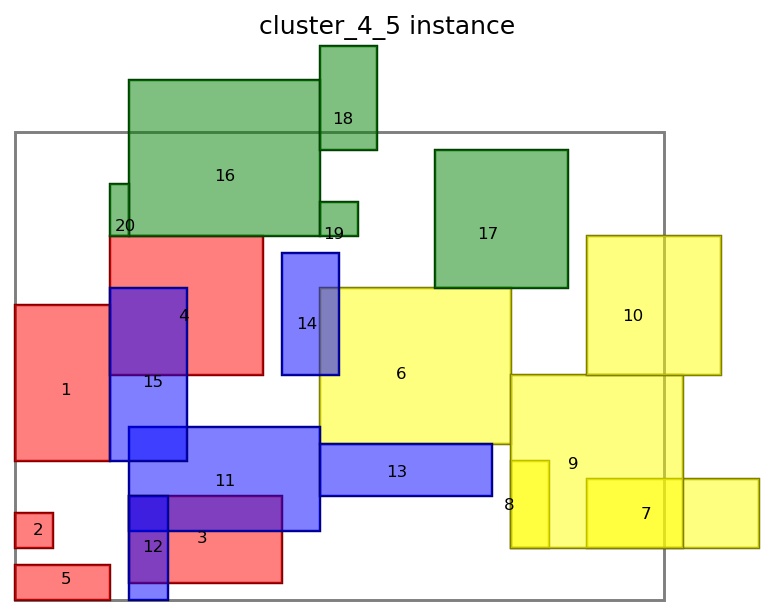


===london_gallery_wall===
objectiveMin=2802.73, objectiveMax=8487.18, objectiveAvg=3471.79, std=1110.06, overlappings=0
xmin=0, xmax=180, ymin=0, ymax=97
grid width=180, grid height=90


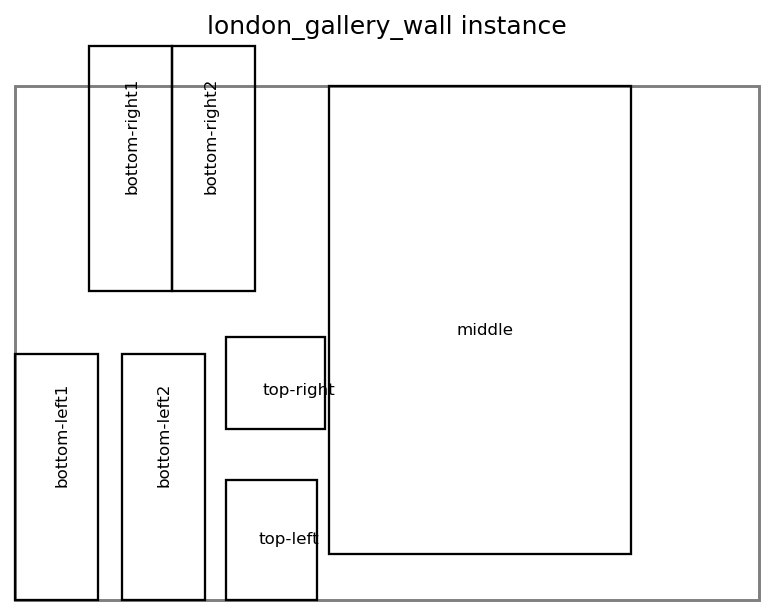

In [142]:
for pack in ['random_10', 'random_20', 'packing_10', 'packing_20', ('cluster_3_6', (3,6)), ('cluster_4_5', (4,5)), 'london_gallery_wall']:
    if isinstance(pack, str): 
        name, cluster = pack, None
    else:
        name, cluster = pack[0], pack[1]
    print(f'==={name}===')
    compRes = loadOneComputationResultsFromDirectoryRec(RESULT_DIR / name)
    drawComputationResult(compRes, lastIterNum=300, cluster=cluster)
    print()

## London National Gallery

objectiveMin=2802.73, objectiveMax=8487.18, objectiveAvg=3471.79, std=1110.06, overlappings=0
xmin=0, xmax=180, ymin=0, ymax=97
grid width=180, grid height=90


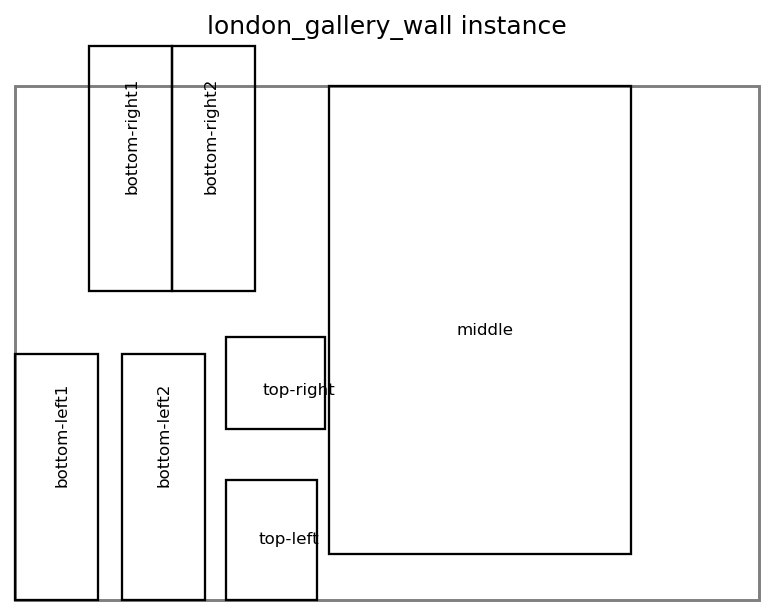

In [141]:
compRes = loadOneComputationResultsFromDirectoryRec(RESULT_DIR / 'london_gallery_wall')
drawComputationResult(compRes, lastIterNum=300, cluster=cluster)